# Delay Learning Example

This basic example demonstrates how to use `TemporalBasisTrafo` in a Keras network. Note that this code is for demonstration purposes only; this particular task could also be solved using least squares.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
import numpy as np
import tensorflow as tf
import scipy.signal
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

import dlop_ldn_function_bases as bases
from temporal_basis_transformation_network import TemporalBasisTrafo

## Training data generation

In [3]:
def nts(T, dt=1e-3):
    return int(T / dt + 1e-9)


def mkrng(rng):
    return np.random.RandomState(rng.randint(1 << 31))


class FilteredGaussianSignal:
    """
    The FilteredGaussianSignal class generates a low-pass filtered white noise
    signal.
    """
    def __init__(self,
                 n_dim=1,
                 freq_low=None,
                 freq_high=1.0,
                 order=4,
                 dt=1e-3,
                 rng=None,
                 rms=0.5):
        assert (not freq_low is None) or (not freq_high is None)

        # Copy the given parameters
        self.n_dim = n_dim
        self.dt = dt
        self.rms = rms

        # Derive a new random number generator from the given rng. This ensures
        # that the signal will always be the same for a given random state,
        # independent of other
        self._rng = mkrng(rng)

        # Build the Butterworth filter
        if freq_low is None:
            btype = "lowpass"
            Wn = freq_high
        elif freq_high is None:
            btype = "highpass"
            Wn = freq_low
        else:
            btype = "bandpass"
            Wn = [freq_low, freq_high]
        self.b, self.a = scipy.signal.butter(N=order,
                                             Wn=Wn,
                                             btype=btype,
                                             analog=False,
                                             output='ba',
                                             fs=1.0 / dt)

        # Scale the output to reach the RMS
        self.b *= rms / np.sqrt(2.0 * dt * freq_high)

        # Initial state
        self.zi = np.zeros((max(len(self.a), len(self.b)) - 1, self.n_dim))

    def __call__(self, n_smpls):
        # Generate some random input
        xs = self._rng.randn(n_smpls, self.n_dim)

        # Filter each dimension independently, save the final state so multiple
        # calls to this function will create a seamless signal
        ys = np.empty((n_smpls, self.n_dim))
        for i in range(self.n_dim):
            ys[:, i], self.zi[:, i] = scipy.signal.lfilter(self.b,
                                                           self.a,
                                                           xs[:, i],
                                                           zi=self.zi[:, i])
        return ys

# Function used to generate the input/target sample pairs
def generate_dataset(N_smpls, N, theta, rng):
    N_delay = int(np.clip(np.floor(N * theta), 0, N))
    sig = FilteredGaussianSignal(N_smpls, dt=1.0 / N, freq_high=10.0, rng=rng)
    xs = sig(N).T
    ys = np.concatenate((
        np.zeros((N_smpls, N_delay)), xs[:, :N_delay]), axis=1)
    return xs, ys

## Network

In [4]:
def learn_delay(H, theta=0.5, N_smpls_train=10000, N_smpls_test=10000, rng=None):
    # Extract the number of basis functions and the number of samples from the
    # given matrix N
    q, N = H.shape

    # Generate the training and test dataset
    xs_train, ys_train = generate_dataset(N_smpls_train, N, theta, rng=rng)
    xs_test, ys_test = generate_dataset(N_smpls_test, N, theta, rng=rng)

    # Build the model
    model = tf.keras.models.Sequential([
        TemporalBasisTrafo(H),
        tf.keras.layers.Dense(1, activation='linear', use_bias=False)
    ])

    # Compile, train, and evaluate the model
    model.compile(optimizer='adam', loss='mse', metrics='mse')
    model.fit(xs_train, ys_train, epochs=10, verbose=False)
    score = model.evaluate(xs_test, ys_test, verbose=False)

    return score, model.layers[1].weights[0].numpy()

## Evaluation

LDN 10 [0.07239995896816254, 0.07239995896816254]
LDN 20 [0.028680983930826187, 0.028680983930826187]
LDN 30 [0.004607948008924723, 0.004607948008924723]
LDN 40 [0.0006034335820004344, 0.0006034335820004344]
DLOP 10 [0.07582642883062363, 0.07582642883062363]
DLOP 20 [0.03654257208108902, 0.03654257208108902]
DLOP 30 [0.007825047709047794, 0.007825047709047794]
DLOP 40 [0.0011206463677808642, 0.0011206463677808642]
Filtered DLOP 10 [0.06035458296537399, 0.06035458296537399]
Filtered DLOP 20 [0.035893864929676056, 0.035893864929676056]
Filtered DLOP 30 [0.00756381219252944, 0.00756381219252944]
Filtered DLOP 40 [0.0011178918648511171, 0.0011178918648511171]
Fourier 10 [0.060226209461688995, 0.060226209461688995]
Fourier 20 [0.010686155408620834, 0.010686155408620834]
Fourier 30 [0.0006686558481305838, 0.0006686558481305838]
Fourier 40 [0.00013227075396571308, 0.00013227075396571308]
Cosine 10 [0.05967915058135986, 0.05967915058135986]
Cosine 20 [0.010814881883561611, 0.010814881883561611

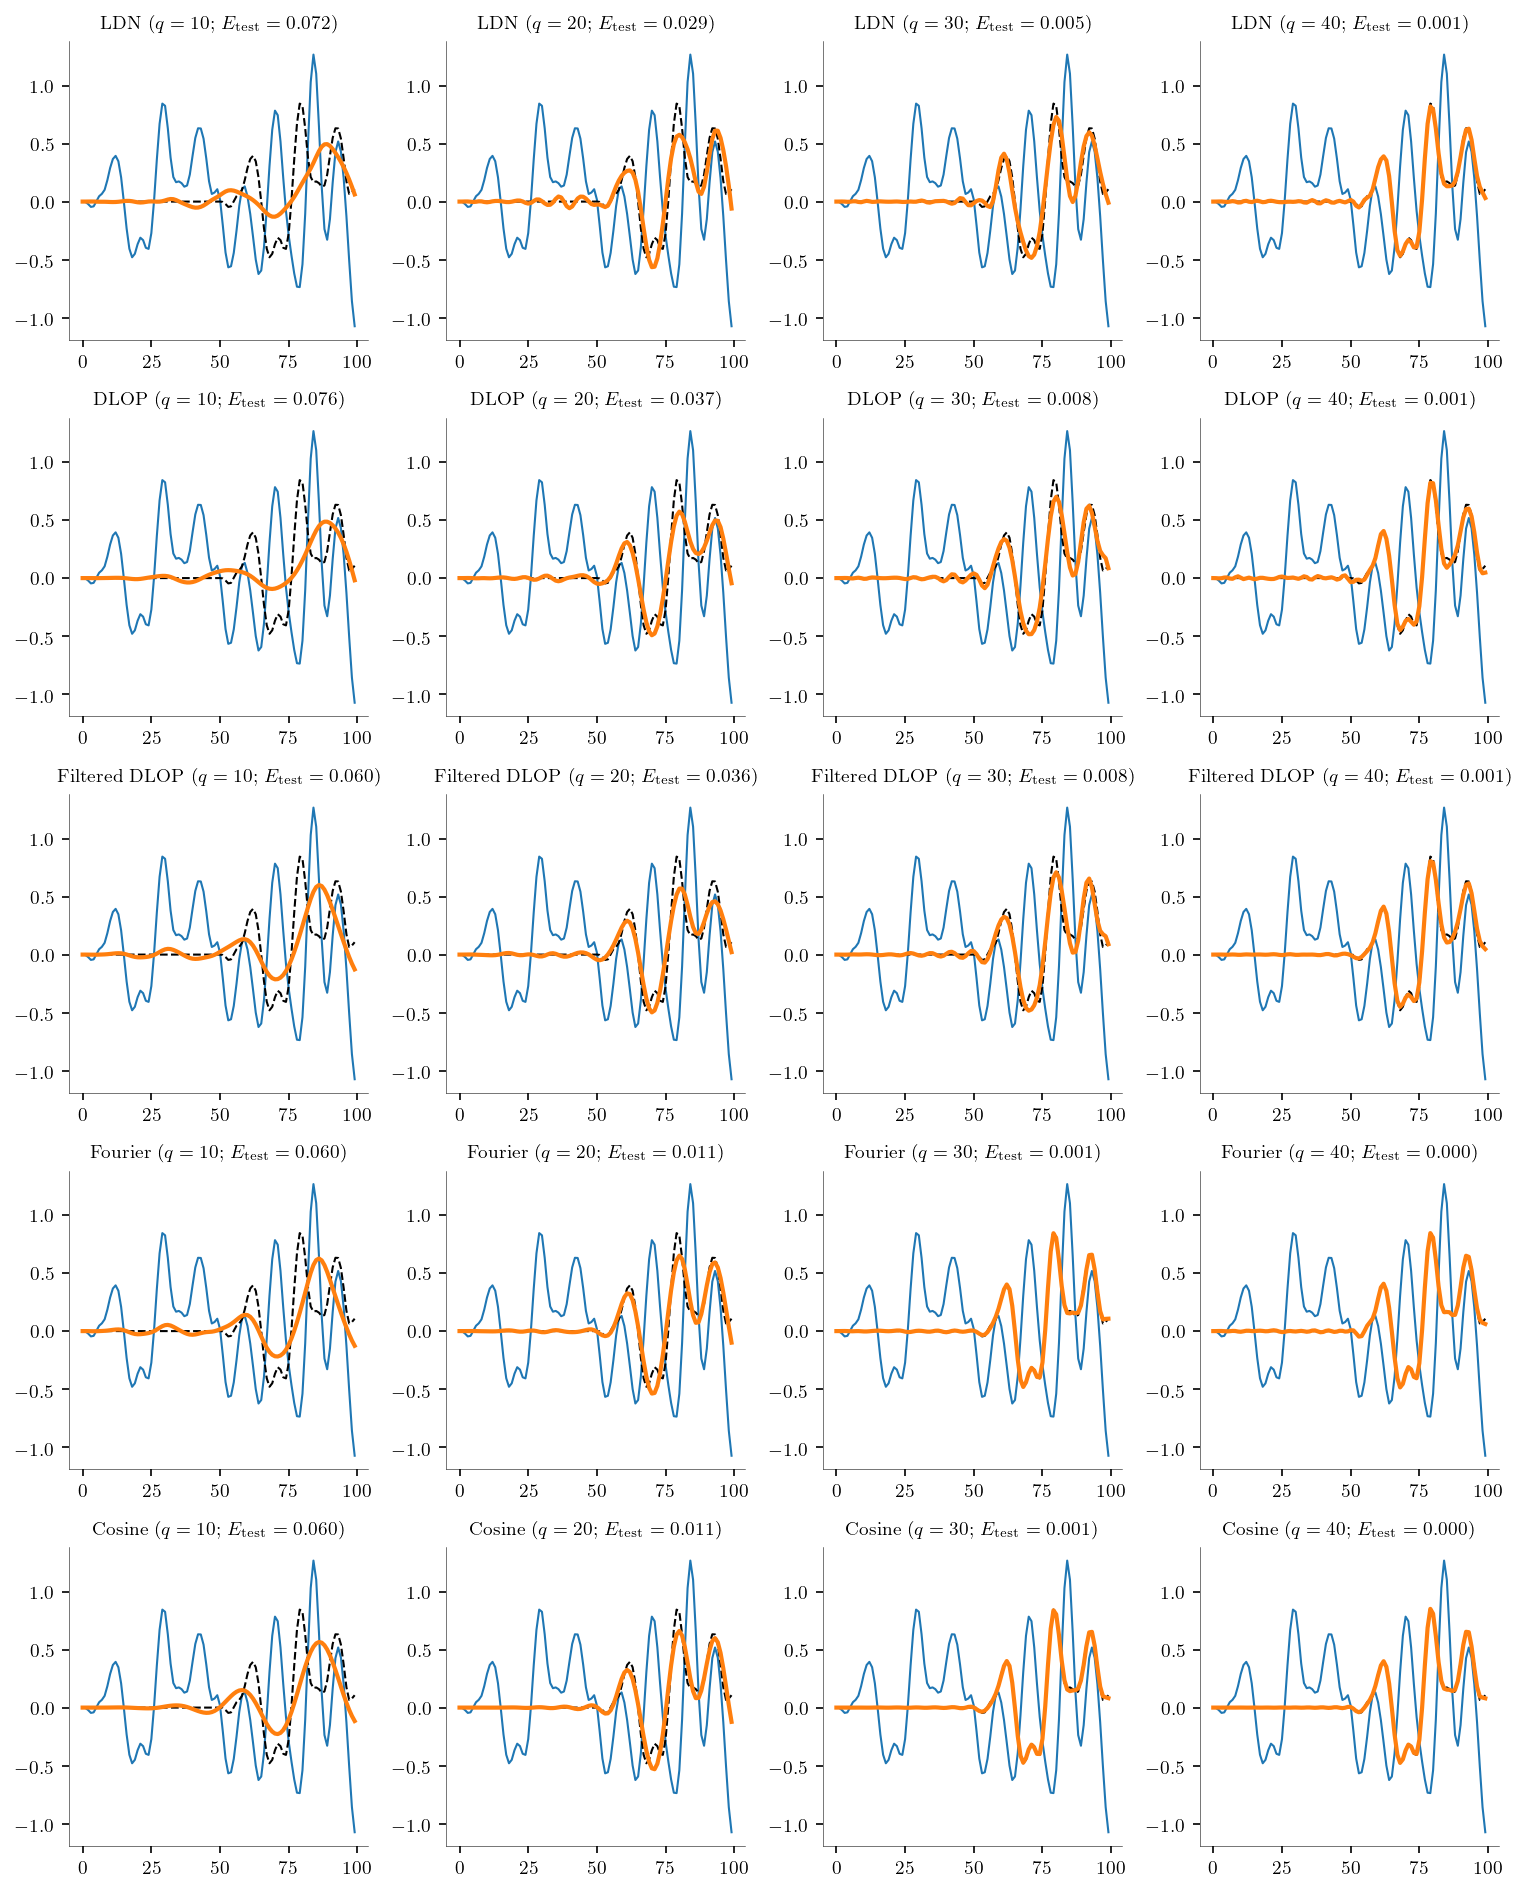

In [5]:
# Bases to try
BASES = (
    (bases.mk_ldn_basis, "LDN"),
    (bases.mk_dlop_basis, "DLOP"),
    (lambda *args: bases.lowpass_filter_basis(bases.mk_dlop_basis(*args)), "Filtered DLOP"),
    (bases.mk_fourier_basis, "Fourier"),
    (bases.mk_cosine_basis, "Cosine"),
)

# QS to try
QS = [10, 20, 30, 40]

# Create a grid of plots
fig, axs = plt.subplots(len(BASES), len(QS), figsize=(2.5 * len(QS), 2.5 * len(BASES)), constrained_layout=True)

# Dataset we're plotting as a visualisation
N, theta = 100, 0.5
rng = np.random.RandomState(15201)
(xs_plot,), (ys_plot,) = generate_dataset(1, N, theta, rng=rng)

for i, (basis_ctor, basis_name) in enumerate(BASES):
    for j, q in enumerate(QS):
        # Generate the basis    
        H = basis_ctor(q, N)

        # Learn the delay
        rng = np.random.RandomState(729241)
        score, W = learn_delay(H, theta, rng=rng)

        # Plot the result
        As = TemporalBasisTrafo(H)(xs_plot).numpy()
        axs[i, j].plot(xs_plot, color='tab:blue', linewidth=1)
        axs[i, j].plot(ys_plot, color='k', linestyle='--', linewidth=1)
        axs[i, j].plot((As @ W), color='tab:orange', linewidth=2)
        axs[i, j].set_title('{} ($q = {}$; $E_\\mathrm{{test}} = {:0.3f}$)'.format(basis_name, q, score[1]))

        print(basis_name, q, score)

In [6]:
fig.savefig('learn_delay_plot.pdf', bbox_inches='tight', transparent=True)